# Imports

In [1]:
#!pip install -r requirements.txt
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [3]:
from google.cloud import bigquery
import json
import ast

In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [5]:
#Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data 

In [6]:
df = pd.read_csv('')
df.shape

(3360229, 56)

After Child Age Imputation, there are 1713 null in Child Age

In [7]:
df['Childs_Age'].isnull().sum()

1713

Dropping those 1713 nulls in child age from df

In [8]:
df = df[df['Childs_Age'].notna()]

In [9]:
df['Childs_Age'].isnull().sum()

0

In [10]:
df.shape

(3358516, 56)

In [11]:
# Some Changes in df
df = df[df['Childs_Age']<=19]
df['Net_Pay'] = df['Net_Pay'].astype(int)
df = df[df['Net_Pay']>0]
print(df.shape[0])

df['Childs_Age'] = df['Childs_Age'].astype(int)
df['PaidTransaction_Date'] = pd.to_datetime(df['PaidTransaction_Date'])
df['Serv_Week'] = pd.to_datetime(df['Serv_Week'])

2889736


# Latency

In [12]:
df['Serv_Week'] = pd.to_datetime(df['Serv_Week'])
df['PaidTransaction_Date'] =  pd.to_datetime(df['PaidTransaction_Date'])
df['Latency'] = df['PaidTransaction_Date'] - df['Serv_Week']
df['Latency'] = df['Latency'].dt.days

# Days Diff1

In [13]:
df['Child_Begin_Care'] = pd.to_datetime(df['Child_Begin_Care'])
df['Days_diff_1'] = df['Serv_Week'] - df['Child_Begin_Care']
df['Days_diff_1'] = df['Days_diff_1'].dt.days

# Net_Gross_Diff

In [14]:
df['Net_Gross_Diff'] = df['Net_Pay']- df['Gross_Paid']
df['Net_Gross_Diff'] = df['Net_Gross_Diff'].replace(np.nan, 0)

# Case and Child _nunique

In [15]:
childcase = df.groupby(['Provider_ID', 'Serv_Week']).rolling(10000, on='PaidTransaction_Date')['Child_PK', 'Case'].count().astype(int).reset_index()
provchild = childcase.groupby(['Provider_ID', 'Serv_Week', 'PaidTransaction_Date']).agg({'Child_PK':'max', 'Case': 'max'}).rename(columns={'Child_PK':'max_child', 'Case': 'max_case'}).reset_index()
groupbydf = pd.DataFrame()
prov = provchild['Provider_ID'].unique()
for i in prov:
    diffchange = provchild.loc[provchild['Provider_ID']==i]
    diffchange.max_case = diffchange['max_case'].diff()
    diffchange.max_child = diffchange['max_child'].diff()
    groupbydf = groupbydf.append(diffchange, ignore_index=True)
groupbydf = groupbydf.rename(columns={'max_child': 'Child_PK_nunique', 'max_case':'Case_nunique'})
df = df.merge(groupbydf, on=['Provider_ID', 'Serv_Week', 'PaidTransaction_Date'])
df.head(1)
print(df.shape)

(2889736, 60)


# FT_Rate_diff

In [16]:
df['FT_Rate_diff'] = df['ProvFTRate'] - df['StateFTRate']
df['FT_Rate_diff'] = df['FT_Rate_diff'].replace(np.nan, 0)

# BA_Rate_diff

In [17]:
df['BA_Rate_diff'] = df['ProvBARate'] - df['StateBARate']
df['BA_Rate_diff'] = df['BA_Rate_diff'].replace(np.nan, 0)

# Number of UAS Codes associated with a provider (n_UAS)

In [18]:
uascount = df.groupby(['Provider_ID', 'Serv_Week']).rolling(10000, on='PaidTransaction_Date')['UAS'].count().astype(int).rename('CountUAS').reset_index()
uasmax = uascount.groupby(['Provider_ID', 'Serv_Week', 'PaidTransaction_Date']).agg({'CountUAS':'max'}).rename(columns={'CountUAS':'max_uas'}).reset_index()
df = df.merge(uasmax,on=['Provider_ID', 'Serv_Week', 'PaidTransaction_Date'])
print(df.shape)

(2889736, 63)


# Max Child Age, Min Child Age wrt UAS (Max_Child_Age_UAS, Min_Child_Age_UAS)

In [19]:
childage = df.groupby(['Provider_ID','Serv_Week','UAS','PaidTransaction_Date']).agg({'Childs_Age':['max','min']}).reset_index()
childage.columns = list(map(''.join, childage.columns.values))
childmaxmin = childage.groupby(['Serv_Week','Provider_ID','PaidTransaction_Date','UAS']).agg({'Childs_Agemax':'max','Childs_Agemin':'min'}).reset_index()
childmaxmin = childmaxmin.rename(columns={'Childs_Agemax':'Max_Child_Age_UAS', 'Childs_Agemin': 'Min_Child_Age_UAS'})
df = df.merge(childmaxmin,on=['Serv_Week','Provider_ID', 'PaidTransaction_Date', 'UAS'])


In [20]:
df.shape

(2889736, 65)

# Number of Children Associated with each UAS Code: 

In [21]:
uascount = (df.groupby(['Provider_ID', 'Serv_Week','UAS']).rolling(10000, on='PaidTransaction_Date')['Child_PK'].count().astype(int).rename('CountChild').reset_index())
maxuas = uascount.groupby(['Serv_Week','Provider_ID','PaidTransaction_Date','UAS']).agg({'CountChild':'max'}).rename(columns={'CountChild':'max_count_child_uas'}).reset_index()
df = df.merge(maxuas,on=['Serv_Week','Provider_ID','PaidTransaction_Date','UAS'])
df.shape


(2889736, 66)

# How many TOCs are associated with the child and the Provider

In [22]:
tocchild = (df.groupby(['Provider_ID', 'TOC', 'Serv_Week']).rolling(10000, on='PaidTransaction_Date')['Child_PK'].count().astype(int).rename('CountChildPK').reset_index())
tocchildmax = tocchild.groupby(['Provider_ID', 'TOC','Serv_Week', 'PaidTransaction_Date']).agg({'CountChildPK':'max'}).rename(columns={'CountChildPK':'max_child_toc'}).reset_index()
df = df.merge(tocchildmax,on=['Provider_ID','TOC', 'Serv_Week', 'PaidTransaction_Date'])
df.shape

(2889736, 67)

# How many TOCs are associated with the child.


In [23]:
toccount = (df.groupby(['Child_PK', 'Serv_Week']).rolling(5000, on='PaidTransaction_Date')['TOC'].count().astype(int).rename('Count_TOC').reset_index())
tocmax = toccount.groupby(['Serv_Week','Child_PK','PaidTransaction_Date']).agg({'Count_TOC':'max'}).rename(columns={'Count_TOC':'max_count_toc'}).reset_index()
df = df.merge(tocmax,on=['Serv_Week','Child_PK','PaidTransaction_Date'])
df.shape


(2889736, 68)

# Difference between the  License Capacity of the Provider and the Actual Capacity (assuming capacity is inclusive of all the tocs, the license capacity is of the same period as the prfCombined)

In [24]:
capacity = pd.read_csv('')
capacity = capacity[['Provider_Number','License_Capacity']]

capacity = capacity.rename(columns={'Provider_Number':'Provider_License'})
df = df.merge(capacity,on=['Provider_License'])

# d = df.groupby(['Provider_ID']).agg({'Child_PK':'nunique'}).reset_index()
# d = d.rename(columns={'Child_PK':'Capacity_from_prf'})

# df = df.merge(d,on=['Provider_ID'])
# df['Difference_Capacity'] = df['License_Capacity'] - df['Capacity_from_prf']
# #df.drop(['License_Capacity','License_Capacity'], axis=1)
# df.columns

In [25]:
childcount = (df.groupby(['Provider_ID', 'Serv_Week']).rolling(5000, on='PaidTransaction_Date')['Child_PK'].count().astype(int).rename('CountChild').reset_index())
childmax = childcount.groupby(['Serv_Week','Provider_ID','PaidTransaction_Date']).agg({'CountChild':'max'}).rename(columns={'CountChild':'max_count_child_capacity'}).reset_index()
df = df.merge(childmax,on=['Serv_Week','Provider_ID','PaidTransaction_Date'])
df['Difference_Capacity']=df['License_Capacity']-df['max_count_child_capacity']
df = df.drop('max_count_child_capacity', axis=1)
df.shape

(2806467, 70)

# Uploading to BigQuery (BQ)

In [31]:
# Construct a BigQuery client object.
project_id = 'mavq-proserv-ga-decal-internal'
client = bigquery.Client(project=project_id)

# Set table_id to the ID of the table model to fetch.
table_id = 'decal.Feature_Engineered_Data'

In [32]:
df.to_gbq(table_id, project_id=project_id, if_exists='append')

lcr_table_schema = [
  {
    "mode": "NULLABLE",
    "name": "Month",
    "type": "STRING"
  }]

100%|██████████| 1/1 [00:00<00:00, 1267.16it/s]


# Reading the data that was saved

In [33]:
client = bigquery.Client(project='mavq-proserv-ga-decal-internal')

fedf = client.query('''
  SELECT *
  
  FROM
    mavq-proserv-ga-decal-internal.decal.Feature_Engineered_Data

  ''').to_dataframe()

In [34]:
fedf

,Case,Child,Cert,UAS,Serv_Week,PaidTransaction_Date,Childs_Age,Provider_Name,Provider_ID,Provider_License,Provider_Address,Provider_City_State_Zip_Code,Region,Provider_County_Code,CAPS_Zone,QR_Star,Tier,TOP,TOC,VSS,FTWeek,Y,StateFTRate,ProvFTRate,StateBARate,ProvBARate,P,StatePTRate,ProvPTRate,Gross_Paid,Adjust,Reg_Fee,Tier_bonus,Child_Fee,Net_Pay,E3ZUAS_630_Amount,Invoice,Provd_Chg,Provd_Diff,Neg_Rate,Child_Begin_Care,Post_111,fileId,incrementalId,Child_PK,ServWeekYear,Latency,DifferentProviders,SameProviders,RegistrationFees,overlapPreK,LargeBilling,ChildrenOverCapacity,PaymentLatency,FamilyUnit,CostPerChild,Days_diff_1,Net_Gross_Diff,Child_PK_nunique,Case_nunique,FT_Rate_diff,BA_Rate_diff,max_uas,Max_Child_Age_UAS,Min_Child_Age_UAS,max_count_child_uas,max_child_toc,max_count_toc,License_Capacity,Difference_Capacity
0,126070640,3,6011186,550,2022-05-30 00:00:00+00:00,2022-07-19 00:00:00+00:00,6,PRIDE & JOY CHILD DEVELOPMENT,54877,CCLC-36670,639 PEARL BATES AVE,"EASTMAN, GA 31023-5533",9,45.0,3,3.0,3.0,Center,Before & After School,Y,Y,4.0,75.0,96.0,45.0,75.0,0.0,21.0,22.0,75.0,0.0,0.0,41.0,3.0,137,NaN,13453630.0,96.0,21.0,75.0,2021-12-18 00:00:00+00:00,X,20220719,1719917,126070640_3,2022,50,0,0,0,0,0,0,0,0,0,163.0,62.0,-4.0,-4.0,21.0,30.0,93,10,0,28,39,1,176,83
1,126384259,1,6072470,550,2022-06-06 00:00:00+00:00,2022-07-19 00:00:00+00:00,3,PRIDE & JOY CHILD DEVELOPMENT,54877,CCLC-36670,639 PEARL BATES AVE,"EASTMAN, GA 31023-5533",9,45.0,3,3.0,3.0,Center,Day Care,N,Y,5.0,80.0,96.0,45.0,80.0,0.0,21.0,NaN,80.0,0.0,0.0,44.0,0.0,140,NaN,13453631.0,96.0,16.0,80.0,2022-03-04 00:00:00+00:00,X,20220719,1720840,126384259_1,2022,43,0,0,0,0,0,0,0,0,0,94.0,60.0,0.0,0.0,16.0,35.0,93,10,0,29,54,1,176,83
2,126890566,1,6114486,547,2022-06-06 00:00:00+00:00,2022-08-16 00:00:00+00:00,3,HINESVILLE CHILD CARE LEARNING CENTER,22506,CCLC-1200,204 MARTIN ST.,"HINESVILLE, GA 31313-",12,89.0,2,3.0,3.0,Center,Day Care,N,Y,5.0,92.0,132.0,60.0,92.0,0.0,27.0,NaN,92.0,0.0,0.0,51.0,11.0,183,NaN,13469174.0,132.0,40.0,92.0,2022-04-30 00:00:00+00:00,X,20220816,1984200,126890566_1,2022,71,0,0,0,0,1,0,1,0,0,37.0,91.0,20.0,20.0,40.0,32.0,22,3,3,1,5,1,101,79
3,119742556,2,5876741,544,2022-07-11 00:00:00+00:00,2022-07-26 00:00:00+00:00,5,"BURNS, BRENDA T.",39809,FR-17248,504 MAGNOLIA STREET,"WRENS, GA 30833-",7,81.0,3,3.0,3.0,Family Home,Before & After School,Y,Y,1.0,80.0,110.0,45.0,75.0,0.0,22.0,25.0,80.0,0.0,0.0,44.0,5.0,154,NaN,13455940.0,110.0,30.0,75.0,2022-05-17 00:00:00+00:00,X,20220726,1791103,119742556_2,2022,15,0,0,0,0,1,0,0,0,0,55.0,74.0,-1.0,-1.0,30.0,30.0,2,5,3,2,1,1,6,4
4,121932493,2,6115788,550,2022-07-11 00:00:00+00:00,2022-07-26 00:00:00+00:00,7,"ADDISON, TRACY D",28723,FR-000009737,"1430 CLAY AVENUE, SW","CAIRO, GA 39828-",10,65.0,3,1.0,1.0,Family Home,Before & After School,Y,Y,4.0,80.0,120.0,45.0,80.0,0.0,22.0,35.0,80.0,0.0,0.0,20.0,11.0,140,NaN,13456563.0,120.0,40.0,80.0,2022-07-06 00:00:00+00:00,X,20220726,1790014,121932493_2,2022,15,0,0,0,0,0,1,0,0,0,5.0,60.0,0.0,0.0,40.0,35.0,8,11,1,4,3,1,6,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806462,126371392,1,6462121,550,2022-11-14 00:00:00+00:00,2022-11-22 00:00:00+00:00,9,ANOINTED HANDS CHILDCARE,75207,CCLC-39622,"1631 GORDON HIGHWAY, SUITE 18-A","AUGUSTA, GA 30906-",7,121.0,2,3.0,3.0,Center,Before & After School,Y,N,3.0,95.0,98.0,65.0,71.0,0.0,30.0,44.0,65.0,0.0,0.0,36.0,13.0,107,NaN,13530114.0,71.0,6.0,65.0,2022-07-13 00:00:00+00:00,X,20221122,2968230,126371392_1,2022,8,0,0,0,0,0,1,0,0,0,124.0,42.0,6.0,6.0,3.0,6.0,126,13,0,78,65,1,96,-30
2806463,127650116,2,6287900,542,2022-12-12 00:00:00+00:00,2022-12-20 00:00:00+00:00,10,ANOINTED HANDS CHILDCARE,75207,CCLC-39622,"1631 GORDON HIGHWAY, SUITE 18-A","AUGUSTA, GA 30906-",7,121.0,2,3.0,3.0,Center,Before & Afte

In [35]:
fedf.shape

(2806467, 70)

# All Rules

Taking union of all the rules as a binary column

In [26]:
cols = ['DifferentProviders', 'SameProviders', 'RegistrationFees', 'overlapPreK', 'LargeBilling', 'ChildrenOverCapacity', 'PaymentLatency', 'FamilyUnit', 'CostPerChild']


In [27]:
df["AllRules"] = np.where(df[cols].any(axis=1), 1, 0)

In [28]:
df.columns

Index(['Case', 'Child', 'Cert', 'UAS', 'Serv_Week', 'PaidTransaction_Date',
       'Childs_Age', 'Provider_Name', 'Provider_ID', 'Provider_License',
       'Provider_Address', 'Provider_City_State_Zip_Code', 'Region',
       'Provider_County_Code', 'CAPS_Zone', 'QR_Star', 'Tier', 'TOP', 'TOC',
       'VSS', 'FTWeek', 'Y', 'StateFTRate', 'ProvFTRate', 'StateBARate',
       'ProvBARate', 'P', 'StatePTRate', 'ProvPTRate', 'Gross_Paid', 'Adjust',
       'Reg_Fee', 'Tier_bonus', 'Child_Fee', 'Net_Pay', 'E3ZUAS_630_Amount',
       'Invoice', 'Provd_Chg', 'Provd_Diff', 'Neg_Rate', 'Child_Begin_Care',
       'Post_111', 'fileId', 'incrementalId', 'Child_PK', 'ServWeekYear',
       'Latency', 'DifferentProviders', 'SameProviders', 'RegistrationFees',
       'overlapPreK', 'LargeBilling', 'ChildrenOverCapacity', 'PaymentLatency',
       'FamilyUnit', 'CostPerChild', 'Days_diff_1', 'Net_Gross_Diff',
       'Child_PK_nunique', 'Case_nunique', 'FT_Rate_diff', 'BA_Rate_diff',
       'max_uas', 'Max_

Creating a subset dataframe to find the correlation between the features created with all the rules

In [39]:
corrdf = df[['AllRules', 'Latency', 'Days_diff_1', 'Net_Gross_Diff', 'Child_PK_nunique', 'Case_nunique',
       'FT_Rate_diff', 'BA_Rate_diff', 'Provd_Diff', 'max_uas', 'Max_Child_Age_UAS',
       'Min_Child_Age_UAS', 'max_count_child_uas', 'max_child_toc',
       'max_count_toc', 'License_Capacity', 'Difference_Capacity','DifferentProviders', 'SameProviders',
       'RegistrationFees', 'overlapPreK', 'LargeBilling',
       'ChildrenOverCapacity', 'PaymentLatency', 'FamilyUnit', 'CostPerChild']]

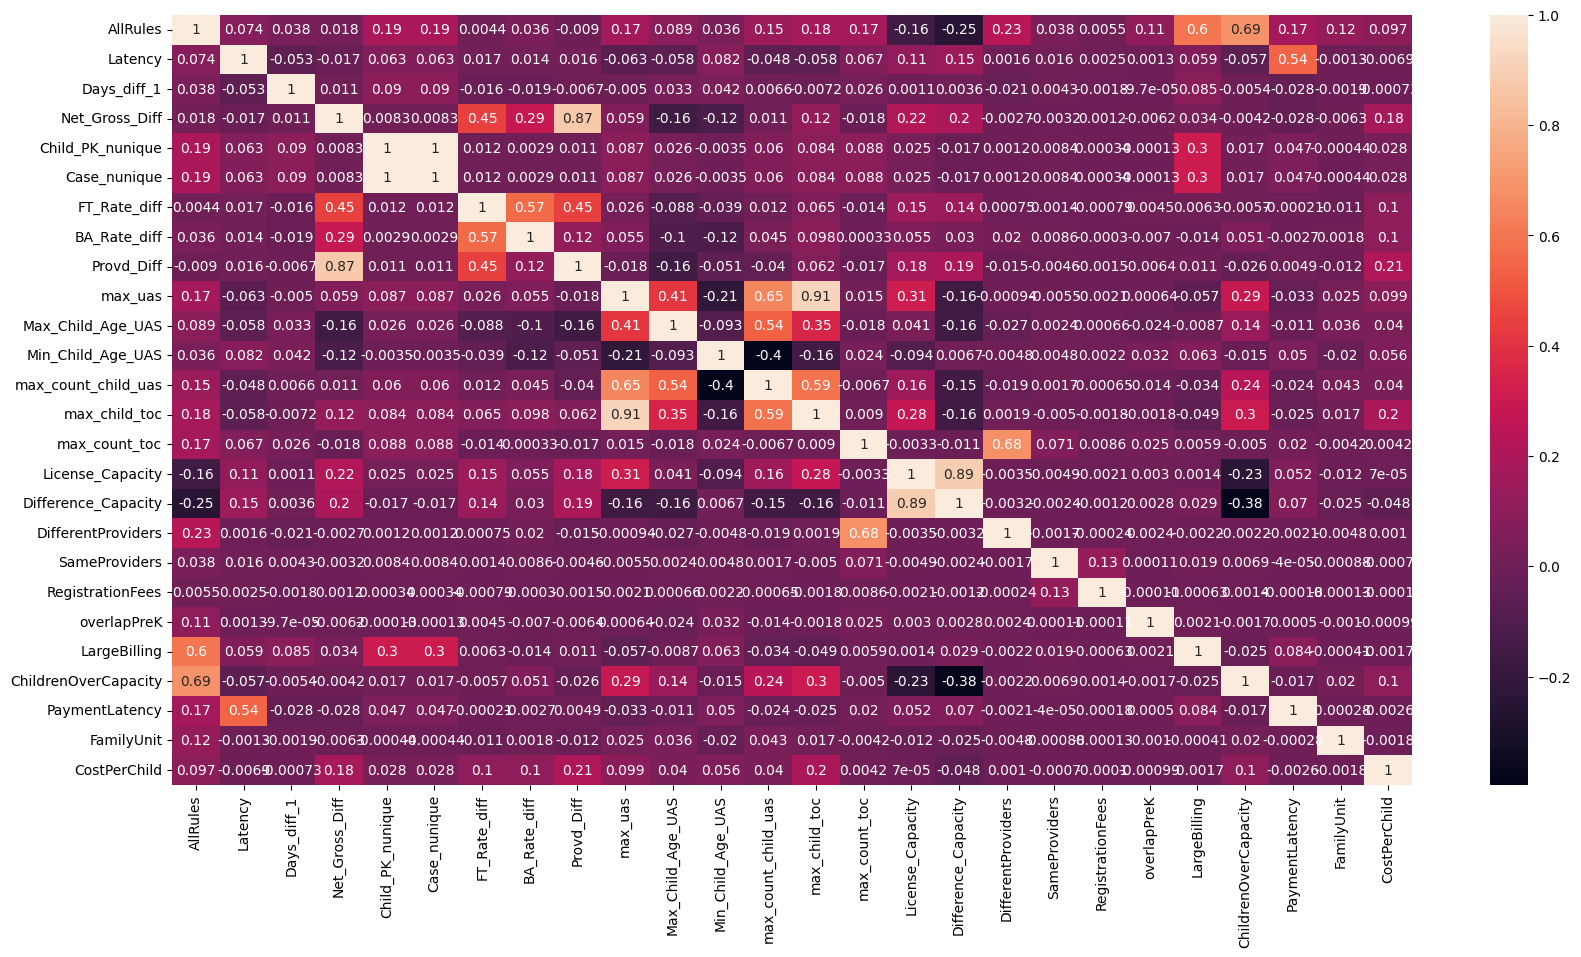

In [40]:
plt.figure(figsize=(20,10))
sns.heatmap(corrdf.corr(method = 'pearson'), annot=True)
plt.show()

AllRules is correlated with Child_PK_nunique, max_uas, max_count_child, max_count_toc, License_Capacity and Difference_Capacity
DifferentProviders - highly correlated with max_count_toc
SameProviders - 
RegistrationFees - 
overlapPreK - 
LargeBilling correlated with Child_PK_nunique
ChildrenOverCapacity correlated with max_uas, Max_Child_Age_UAS, max_count_child_uas, License_Capacity and Difference_Capacity
PaymentLatency is correlated with Latency
FamilyUnit - 
CostPerChild is correlated with Net_Gross_Diff, FT_Rate_diff, BA_Rate_Diff, Provd_Diff, ,max_child_toc

# Model 

## Taking into account the new features that were created

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [42]:
#Set of independent variables
X = df[['Latency', 'Days_diff_1', 'Net_Gross_Diff', 'Child_PK_nunique', 'Case_nunique',
       'FT_Rate_diff', 'BA_Rate_diff', 'Provd_Diff', 'max_uas', 'Max_Child_Age_UAS',
       'Min_Child_Age_UAS', 'max_count_child_uas', 'max_child_toc',
       'max_count_toc', 'License_Capacity', 'Difference_Capacity']]

In [43]:
#Dependent variable
y = df["AllRules"]

In [44]:
#Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2245173, 16) (561294, 16) (2245173,) (561294,)


In [30]:
from xgboost import XGBClassifier

In [46]:
#Creating xgb classifier
xgb_clf = XGBClassifier()

#Fitting the model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [47]:
#Predicting X_test
xgbprediction = xgb_clf.predict(X_test)

Checking feature importance

In [48]:
feature_important = xgb_clf.get_booster().get_score(importance_type='weight')
feature_important_sort = dict(sorted(feature_important.items(), key=lambda x:-1*x[1]))
feature_important_sort

{'Child_PK_nunique': 750.0,
 'max_uas': 733.0,
 'Difference_Capacity': 577.0,
 'License_Capacity': 458.0,
 'Days_diff_1': 330.0,
 'max_child_toc': 330.0,
 'Net_Gross_Diff': 312.0,
 'Latency': 303.0,
 'BA_Rate_diff': 248.0,
 'Provd_Diff': 217.0,
 'FT_Rate_diff': 211.0,
 'max_count_child_uas': 186.0,
 'Max_Child_Age_UAS': 155.0,
 'Min_Child_Age_UAS': 108.0,
 'max_count_toc': 106.0}

In [49]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import classification_report

In [50]:
classification_report_oversample = classification_report(y_test, xgbprediction)
print(classification_report_oversample)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    470756
           1       0.95      0.72      0.82     90538

    accuracy                           0.95    561294
   macro avg       0.95      0.86      0.90    561294
weighted avg       0.95      0.95      0.95    561294



In [51]:
cm= confusion_matrix(y_test, xgbprediction)  
cm

array([[467324,   3432],
       [ 25078,  65460]])

Displaying the confusion matrix

[[467324   3432]
 [ 25078  65460]]


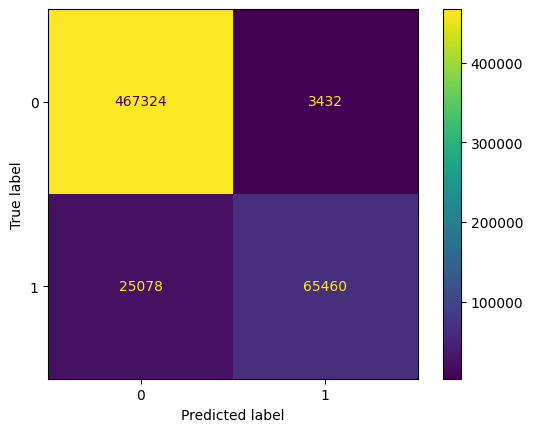

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, xgbprediction, labels=xgb_clf.classes_)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot()
plt.show()

Getting false positive rows

In [53]:
X_test[(y_test == 0) & (xgbprediction == 1)]

,Latency,Days_diff_1,Net_Gross_Diff,Child_PK_nunique,Case_nunique,FT_Rate_diff,BA_Rate_diff,Provd_Diff,max_uas,Max_Child_Age_UAS,Min_Child_Age_UAS,max_count_child_uas,max_child_toc,max_count_toc,License_Capacity,Difference_Capacity
378376,22,96.0,51.0,4.0,4.0,0.0,0.0,26.0,17,11,0,5,12,1,217,200
2674913,8,138.0,146.0,8.0,8.0,111.0,35.0,111.0,45,12,1,14,26,1,188,143
669473,8,202.0,40.0,2.0,2.0,0.0,0.0,NaN,82,12,1,12,45,2,130,48
1848274,22,1274.0,40.0,-3.0,-3.0,0.0,0.0,21.0,2,5,3,2,1,1,110,108
272134,8,48.0,61.0,0.0,0.0,0.0,0.0,38.0,34,12,1,17,13,2,67,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410120,8,159.0,27.0,0.0,0.0,8.0,11.0,11.0,98,12,5,4,49,1,99,1
2494518,8,193.0,36.0,2.0,2.0,0.0,0.0,NaN,8,7,7,1,3,1,152,144
1559986,8,144.0,60.0,0.0,0.0,20.0,37.0,20.0,61,13,0,44,33,2,70,9
1314177,8,61.0,94.0,2.0,2.0,-5.0,35.0,0.0,40,11,0,24,10,1,40,0


# With all attributes

## Data Preparation 

In [31]:
df.isnull().sum()

Case                                  0
Child                                 0
Cert                                  0
UAS                                   0
Serv_Week                             0
PaidTransaction_Date                  0
Childs_Age                            0
Provider_Name                         0
Provider_ID                           0
Provider_License                      0
Provider_Address                      0
Provider_City_State_Zip_Code          0
Region                                0
Provider_County_Code                  0
CAPS_Zone                             0
QR_Star                           81153
Tier                              50335
TOP                                   0
TOC                                   0
VSS                             1442127
FTWeek                          1442127
Y                               1442127
StateFTRate                     1442127
ProvFTRate                      1442127
StateBARate                     1442127


Creating Age Bins

In [32]:
bins = [-1, 0, 1, 2, 5, 23]
labels = ['Zero', '0 to 1', '1 to 2', '3 to 5', 'Above 6']
df['binned'] = pd.cut(df['Childs_Age'], bins, labels=labels)

In [33]:
df['binned'].value_counts()

3 to 5     1042001
Above 6    1011258
1 to 2      354615
0 to 1      298595
Zero         99998
Name: binned, dtype: int64

One hot encoding on Region, TOP, TOC, VSS and Age bins

In [34]:
one_hot_encoded_data = pd.get_dummies(df, columns = ['Region', 'TOP', 'TOC', 'VSS', 'binned'])

Label Encoding for UAS

In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cols = ['UAS']
#
# Encode labels of multiple columns at once
#
one_hot_encoded_data[cols] = one_hot_encoded_data[cols].apply(LabelEncoder().fit_transform)
one_hot_encoded_data

,Case,Child,Cert,UAS,Serv_Week,PaidTransaction_Date,Childs_Age,Provider_Name,Provider_ID,Provider_License,Provider_Address,Provider_City_State_Zip_Code,Provider_County_Code,CAPS_Zone,QR_Star,Tier,FTWeek,Y,StateFTRate,ProvFTRate,StateBARate,ProvBARate,P,StatePTRate,ProvPTRate,Gross_Paid,Adjust,Reg_Fee,Tier_bonus,Child_Fee,Net_Pay,E3ZUAS_630_Amount,Invoice,Provd_Chg,Provd_Diff,Neg_Rate,Child_Begin_Care,Post_111,fileId,incrementalId,Child_PK,ServWeekYear,Latency,DifferentProviders,SameProviders,RegistrationFees,overlapPreK,LargeBilling,ChildrenOverCapacity,PaymentLatency,FamilyUnit,CostPerChild,Days_diff_1,Net_Gross_Diff,Child_PK_nunique,Case_nunique,FT_Rate_diff,BA_Rate_diff,max_uas,Max_Child_Age_UAS,Min_Child_Age_UAS,max_count_child_uas,max_child_toc,max_count_toc,License_Capacity,Difference_Capacity,AllRules,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,Region_11,Region_12,Region_14,TOP_Center,TOP_Family Home,TOC_Before & After School,TOC_Day Care,TOC_Night,TOC_Part Time,VSS_N,VSS_Y,binned_Zero,binned_0 to 1,binned_1 to 2,binned_3 to 5,binned_Above 6
0,123412964,1,5689330,16,2021-05-24,2022-01-04,1,"CAMPBELL, PAMELA F",52902,FR-18026,709 DEERING ROAD,"CONYERS, GA 30094-",122.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70.0,0.0,7.0,NaN,77,NaN,3545843.0,125.0,125.0,125.0,2020-11-02,NaN,20220104,0,123412964_1,2021,225,0,0,0,0,0,0,1,0,0,203.0,77.0,NaN,NaN,0.0,0.0,1,1,1,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
1,123412964,1,5689330,16,2021-05-31,2022-01-04,1,"CAMPBELL, PAMELA F",52902,FR-18026,709 DEERING ROAD,"CONYERS, GA 30094-",122.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70.0,0.0,7.0,NaN,77,NaN,3545843.0,125.0,125.0,125.0,2020-11-02,NaN,20220104,6,123412964_1,2021,218,0,0,0,0,0,0,1,0,0,210.0,77.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,123412964,1,5689330,16,2021-06-07,2022-01-04,1,"CAMPBELL, PAMELA F",52902,FR-18026,709 DEERING ROAD,"CONYERS, GA 30094-",122.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70.0,0.0,7.0,NaN,77,NaN,3545844.0,125.0,125.0,125.0,2020-11-02,NaN,20220104,13,123412964_1,2021,211,0,0,0,0,0,0,1,0,0,217.0,77.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,123412964,1,5689330,16,2021-06-14,2022-01-04,1,"CAMPBELL, PAMELA F",52902,FR-18026,709 DEERING ROAD,"CONYERS, GA 30094-",122.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70.0,0.0,7.0,NaN,77,NaN,3545844.0,125.0,125.0,125.0,2020-11-02,NaN,20220104,20,123412964_1,2021,204,0,0,0,0,0,0,1,0,0,224.0,77.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
4,123412964,1,5689330,16,2021-06-21,2022-01-04,1,"CAMPBELL, PAMELA F",52902,FR-18026,709 DEERING ROAD,"CONYERS, GA 30094-",122.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70.0,0.0,7.0,NaN,77,NaN,3545844.0,125.0,125.0,125.0,2020-11-02,NaN,20220104,27,123412964_1,2021,197,0,0,0,0,0,0,1,0,0,231.0,77.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806462,126872047,1,6616247,16,2022-10-31,2022-12-27,12,ICARE @ TOCCOA,142846,CCLC-57828,1760 W. CURRAHEE STREET,"TOCCOA, GA 30577-",127.0,3,1.0,0.0,N,4.0,85.0,465.0,50.0,325.0,0.0,24.0,100.0,325.0,0.0,65.0,0.0,0.0,390,NaN,13548135.0,325.0,0.0,325.0,2022-07-13,X,20221227,3291035,126872047_1,2022,57,0,0,0,0,0,0,0,0,1,110.0,65.0,NaN,NaN,380.0,275.0,36,12,4,6,20,1,108,72,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
2806463,122379026,1,6616244,16,2022-10-31,2022-12-27,5,ICARE @ TOCCOA,142846,CCLC-57828,1760 W. CURRAHEE STREET,"TOCCOA

Filtering the data to remove onject and datetime64[ns] columns
Dropping not required columns from the dataframe 
Getting the final data for modelling

In [36]:
typedf = one_hot_encoded_data.select_dtypes(exclude=['object', 'datetime64[ns]'])
modeldf = typedf.drop(['Case', 'Child', 'Cert', 'Childs_Age', 'Provider_ID', 'Y', 'StateFTRate', 'ProvFTRate', 'StateBARate', 'ProvBARate', 'P', 'StatePTRate', 'ProvPTRate', 'E3ZUAS_630_Amount', 'Invoice', 'Provd_Chg', 'fileId', 'incrementalId', 'ServWeekYear'], axis=1)
modeldf 

,UAS,Provider_County_Code,CAPS_Zone,QR_Star,Tier,Gross_Paid,Adjust,Reg_Fee,Tier_bonus,Child_Fee,Net_Pay,Provd_Diff,Neg_Rate,Latency,DifferentProviders,SameProviders,RegistrationFees,overlapPreK,LargeBilling,ChildrenOverCapacity,PaymentLatency,FamilyUnit,CostPerChild,Days_diff_1,Net_Gross_Diff,Child_PK_nunique,Case_nunique,FT_Rate_diff,BA_Rate_diff,max_uas,Max_Child_Age_UAS,Min_Child_Age_UAS,max_count_child_uas,max_child_toc,max_count_toc,License_Capacity,Difference_Capacity,AllRules,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,Region_11,Region_12,Region_14,TOP_Center,TOP_Family Home,TOC_Before & After School,TOC_Day Care,TOC_Night,TOC_Part Time,VSS_N,VSS_Y,binned_Zero,binned_0 to 1,binned_1 to 2,binned_3 to 5,binned_Above 6
0,16,122.0,1,1.0,1.0,0.0,70.0,0.0,7.0,NaN,77,125.0,125.0,225,0,0,0,0,0,0,1,0,0,203.0,77.0,NaN,NaN,0.0,0.0,1,1,1,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
1,16,122.0,1,1.0,1.0,0.0,70.0,0.0,7.0,NaN,77,125.0,125.0,218,0,0,0,0,0,0,1,0,0,210.0,77.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,16,122.0,1,1.0,1.0,0.0,70.0,0.0,7.0,NaN,77,125.0,125.0,211,0,0,0,0,0,0,1,0,0,217.0,77.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,16,122.0,1,1.0,1.0,0.0,70.0,0.0,7.0,NaN,77,125.0,125.0,204,0,0,0,0,0,0,1,0,0,224.0,77.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
4,16,122.0,1,1.0,1.0,0.0,70.0,0.0,7.0,NaN,77,125.0,125.0,197,0,0,0,0,0,0,1,0,0,231.0,77.0,0.0,0.0,0.0,0.0,1,1,1,1,1,1,6,5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806462,16,127.0,3,1.0,0.0,325.0,0.0,65.0,0.0,0.0,390,0.0,325.0,57,0,0,0,0,0,0,0,0,1,110.0,65.0,NaN,NaN,380.0,275.0,36,12,4,6,20,1,108,72,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
2806463,16,127.0,3,1.0,0.0,325.0,0.0,65.0,0.0,0.0,390,0.0,325.0,57,0,0,0,0,0,0,0,0,1,110.0,65.0,NaN,NaN,375.0,275.0,36,12,4,6,20,1,108,72,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
2806464,14,127.0,3,1.0,0.0,50.0,0.0,65.0,0.0,2.0,390,275.0,50.0,57,0,0,0,0,0,0,0,0,1,110.0,340.0,NaN,NaN,-40.0,275.0,36,4,4,1,20,1,108,72,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
2806465,6,127.0,3,1.0,0.0,50.0,0.0,65.0,0.0,31.0,390,275.0,50.0,57,0,0,0,0,0,0,0,0,1,110.0,340.0,NaN,NaN,-35.0,275.0,36,10,2,6,20,1,108,72,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1


Doing standard scaling on some of the columns

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(modeldf[['Gross_Paid', 'Adjust', 'Reg_Fee', 'Tier_bonus', 'Net_Pay']])
modeldf[['Gross_Paid', 'Adjust', 'Reg_Fee', 'Tier_bonus', 'Net_Pay']] = scaler.transform(modeldf[['Gross_Paid', 'Adjust', 'Reg_Fee', 'Tier_bonus', 'Net_Pay']])


Checking null values

In [38]:
modeldf.isnull().sum()

UAS                               0
Provider_County_Code              0
CAPS_Zone                         0
QR_Star                       81153
Tier                          50335
Gross_Paid                        0
Adjust                            0
Reg_Fee                           0
Tier_bonus                        0
Child_Fee                    381705
Net_Pay                           0
Provd_Diff                   424474
Neg_Rate                       7517
Latency                           0
DifferentProviders                0
SameProviders                     0
RegistrationFees                  0
overlapPreK                       0
LargeBilling                      0
ChildrenOverCapacity              0
PaymentLatency                    0
FamilyUnit                        0
CostPerChild                      0
Days_diff_1                    2013
Net_Gross_Diff                    0
Child_PK_nunique              33133
Case_nunique                  33133
FT_Rate_diff                

Dropping null rows present in QR_Star and Child_Fee columns

In [39]:
modeldf = modeldf.dropna(subset=['QR_Star', 'Child_Fee'])

Replacing null rows with zero

In [40]:
modeldf = modeldf.fillna(0)

## Taking into account all the features after data preprocessing

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [42]:
#Set of independent variables
X = modeldf.drop(['AllRules', 'DifferentProviders', 'SameProviders',
       'RegistrationFees', 'overlapPreK', 'LargeBilling',
       'ChildrenOverCapacity', 'PaymentLatency', 'FamilyUnit', 'CostPerChild'], axis=1)


In [43]:
#Dependent variable
y = modeldf["AllRules"]

In [44]:
#Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1893935, 54) (473484, 54) (1893935,) (473484,)


In [45]:
from xgboost import XGBClassifier

In [46]:
#Creating xgb classifier
xgb_clf = XGBClassifier()

#Fitting the model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [47]:
#Predicting X_test
xgbprediction = xgb_clf.predict(X_test)

Checking feature importance

In [48]:
feature_important = xgb_clf.get_booster().get_score(importance_type='weight')
feature_important2 = dict(sorted(feature_important.items(), key=lambda x:-1*x[1]))
feature_important2

{'max_uas': 611.0,
 'Child_PK_nunique': 606.0,
 'Difference_Capacity': 461.0,
 'max_child_toc': 295.0,
 'License_Capacity': 266.0,
 'Days_diff_1': 229.0,
 'Provider_County_Code': 226.0,
 'Latency': 225.0,
 'FT_Rate_diff': 175.0,
 'max_count_child_uas': 155.0,
 'BA_Rate_diff': 144.0,
 'Net_Pay': 115.0,
 'Net_Gross_Diff': 106.0,
 'Neg_Rate': 96.0,
 'Gross_Paid': 83.0,
 'Tier_bonus': 76.0,
 'Provd_Diff': 74.0,
 'Max_Child_Age_UAS': 74.0,
 'UAS': 71.0,
 'Min_Child_Age_UAS': 64.0,
 'Child_Fee': 62.0,
 'QR_Star': 53.0,
 'max_count_toc': 52.0,
 'Reg_Fee': 47.0,
 'Region_10': 39.0,
 'TOC_Before & After School': 32.0,
 'Adjust': 31.0,
 'VSS_Y': 31.0,
 'Tier': 30.0,
 'Region_4': 28.0,
 'CAPS_Zone': 27.0,
 'Region_3': 22.0,
 'Region_8': 20.0,
 'Region_5': 19.0,
 'TOC_Day Care': 19.0,
 'Region_14': 18.0,
 'Region_1': 14.0,
 'binned_Above 6': 14.0,
 'Region_11': 13.0,
 'Region_12': 13.0,
 'binned_1 to 2': 13.0,
 'Region_9': 12.0,
 'binned_0 to 1': 12.0,
 'binned_3 to 5': 10.0,
 'Region_7': 8.0,
 'V

In [49]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import classification_report

In [50]:
classification_report_oversample = classification_report(y_test, xgbprediction)
print(classification_report_oversample)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    397208
           1       0.96      0.74      0.84     76276

    accuracy                           0.95    473484
   macro avg       0.95      0.87      0.91    473484
weighted avg       0.95      0.95      0.95    473484



In [51]:
cm= confusion_matrix(y_test, xgbprediction)  
cm

array([[394635,   2573],
       [ 19481,  56795]])

Displaying confusion matrix

[[394635   2573]
 [ 19481  56795]]


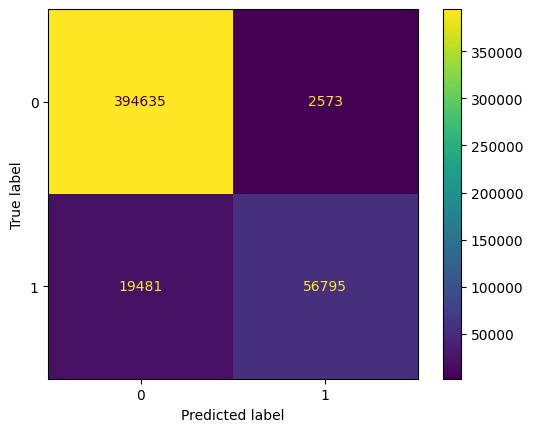

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, xgbprediction, labels=xgb_clf.classes_)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot()
plt.show()

Getting false positive rows

In [53]:
falseposdf = X_test[(y_test == 0) & (xgbprediction == 1)]
falseposdf

,UAS,Provider_County_Code,CAPS_Zone,QR_Star,Tier,Gross_Paid,Adjust,Reg_Fee,Tier_bonus,Child_Fee,Net_Pay,Provd_Diff,Neg_Rate,Latency,Days_diff_1,Net_Gross_Diff,Child_PK_nunique,Case_nunique,FT_Rate_diff,BA_Rate_diff,max_uas,Max_Child_Age_UAS,Min_Child_Age_UAS,max_count_child_uas,max_child_toc,max_count_toc,License_Capacity,Difference_Capacity,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,Region_11,Region_12,Region_14,TOP_Center,TOP_Family Home,TOC_Before & After School,TOC_Day Care,TOC_Night,TOC_Part Time,VSS_N,VSS_Y,binned_Zero,binned_0 to 1,binned_1 to 2,binned_3 to 5,binned_Above 6
2215328,4,44.0,1,1.0,1.0,0.434580,-0.015561,3.968169,-0.237800,19.0,0.444424,0.0,75.0,8,1407.0,76.0,0.0,0.0,0.0,0.0,2,15,10,2,2,1,38,36,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1
2614635,6,49.0,3,1.0,1.0,-1.762741,-0.015561,-0.176241,-1.413215,29.0,-1.591578,10.0,40.0,36,100.0,20.0,-2.0,-2.0,0.0,0.0,4,8,3,2,1,1,6,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
1771973,12,16.0,2,1.0,1.0,0.176072,-0.015561,-0.176241,-0.349744,13.0,-0.234243,10.0,102.0,8,115.0,39.0,0.0,0.0,10.0,37.0,46,8,0,18,37,1,47,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0
2149256,16,28.0,1,2.0,2.0,3.976145,-0.015561,-0.176241,3.176499,0.0,2.653703,0.0,262.0,15,195.0,92.0,2.0,2.0,125.0,182.0,7,3,3,1,6,1,157,150,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1777523,12,137.0,2,2.0,2.0,-0.211691,-0.015561,-0.176241,-0.013912,1.0,0.776538,89.0,100.0,8,19.0,124.0,3.0,3.0,89.0,35.0,85,13,0,52,40,1,107,22,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241022,6,67.0,1,3.0,3.0,1.313509,-0.015561,-0.176241,2.896638,18.0,2.408228,91.0,159.0,8,26.0,178.0,4.0,4.0,91.0,79.0,15,10,1,5,9,1,254,239,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0
2726981,10,146.0,3,1.0,1.0,-0.728708,-0.015561,-0.176241,-0.853493,5.0,-0.219803,55.0,80.0,8,37.0,75.0,2.0,2.0,0.0,0.0,8,9,3,3,4,1,143,135,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
2802082,10,67.0,1,1.0,1.0,1.313509,-0.015561,-0.176241,0.265949,0.0,1.556283,79.0,165.0,15,88.0,119.0,2.0,2.0,79.0,85.0,7,7,0,3,6,1,26,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0
2641574,6,60.0,1,2.0,0.0,-0.987216,-0.015561,5.810129,-1.972936,16.0,-0.436399,5.0,70.0,8,-3.0,70.0,-4.0,-4.0,0.0,0.0,3,8,6,3,3,1,37,34,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1
